In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# Loading Data

In [2]:

csv_file_path = "CK+ Dataset/ckextended.csv"
dataset = pd.read_csv(csv_file_path)
dataset.head()


,emotion,pixels,Usage
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...,Training
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...,Training
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...,Training
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...,Training
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...,Training


In [3]:
emotion_mapping = {
    0: 'Anger',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happiness',
    4: 'Sadness',
    5: 'Surprise',
    6: 'Neutral',
    7: 'Contempt'
}


In [4]:
# Initialize a dictionary to store counts of each emotion
emotion_counts = {}

# Iterate over the emotion mapping dictionary to get emotion IDs and names
for emotion_id, emotion_name in emotion_mapping.items():
    # Count the occurrences of each emotion ID in the dataset
    count = dataset['emotion'].eq(emotion_id).sum()
    # Store the count with the corresponding emotion name in the dictionary
    emotion_counts[emotion_name] = count

# Display the counts of each emotion
print("Emotion Counts:")
for emotion_name, count in emotion_counts.items():
    # Print the emotion name and its corresponding count
    print(f"{emotion_name}: {count} samples")


Emotion Counts:
Anger: 45 samples
Disgust: 59 samples
Fear: 25 samples
Happiness: 69 samples
Sadness: 28 samples
Surprise: 83 samples
Neutral: 593 samples
Contempt: 18 samples


In [5]:
# How many classes are there?
num_classes = len(emotion_counts)
print(f"\nNumber of classes: {num_classes}")



Number of classes: 8


# Splitting the data into a training and a test set

In [6]:
# Filter the dataset to get the training set
Train_set = dataset[dataset['Usage'] == 'Training']

# Remove samples with emotion "Contempt"
Train_set = Train_set[Train_set['emotion'] != 7]

# Drop the 'Usage' column as it's no longer needed
Train_set.drop('Usage', axis=1, inplace=True)

# Reset the index of the DataFrame after filtering
Train_set.reset_index(drop=True, inplace=True)

# Display the first few rows of the cleaned training set
Train_set.head()


,emotion,pixels
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...


In [7]:
# Filter the dataset to get the test set
Test_set = dataset[dataset['Usage'] == 'PrivateTest']

# Remove samples with emotion "Contempt"
Test_set = Test_set[Test_set['emotion'] != 7]

# Drop the 'Usage' column as it's no longer needed
Test_set.drop('Usage', axis=1, inplace=True)

# Reset the index of the DataFrame after filtering
Test_set.reset_index(drop=True, inplace=True)

# Display the first few rows of the cleaned test set
Test_set.head()


,emotion,pixels
0,6,72 72 65 70 58 48 23 21 17 28 42 34 50 82 108 ...
1,6,50 36 9 4 3 4 9 13 20 55 91 123 148 158 174 18...
2,6,0 0 0 0 0 0 0 0 5 13 9 1 0 0 2 14 10 13 4 1 8 ...
3,6,19 21 21 15 10 3 26 30 32 29 10 18 48 58 50 56...
4,6,64 68 65 70 69 69 67 30 11 17 17 13 19 21 49 6...


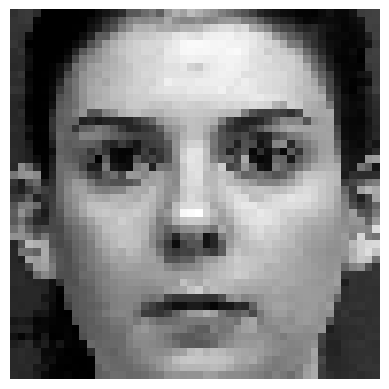

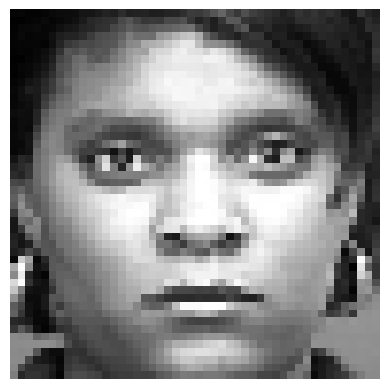

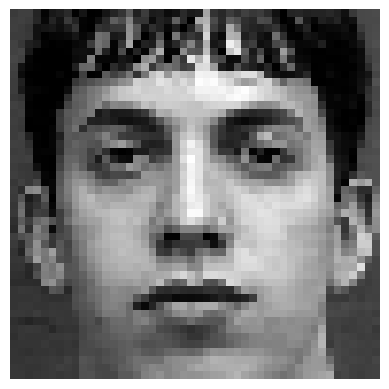

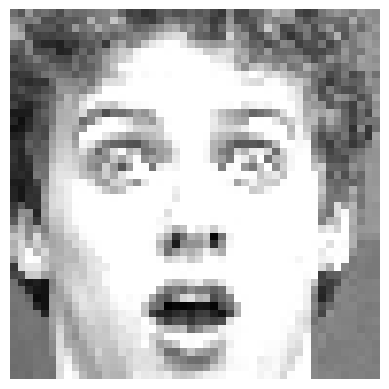

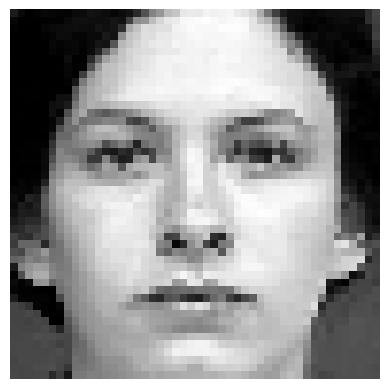

In [8]:
pixels_column = dataset['pixels']

# Function to convert a string of pixel values to a NumPy array
def string_to_pixels(pixel_string):
    pixel_array = np.array(pixel_string.split(), dtype=np.uint8)
    return pixel_array.reshape(48, 48)  #  images are 48x48 pixels

# Choose the number of images to visualize
num_images_to_visualize = 5

# Select random rows from the DataFrame
random_rows = pixels_column.sample(num_images_to_visualize)

# Convert pixel strings to NumPy arrays and visualize the images
for idx, pixel_string in random_rows.items():  
    pixel_array = string_to_pixels(pixel_string)

    # Display the image
    plt.imshow(pixel_array, cmap='gray')  #  grayscale images
    plt.axis('off')  
    plt.show()

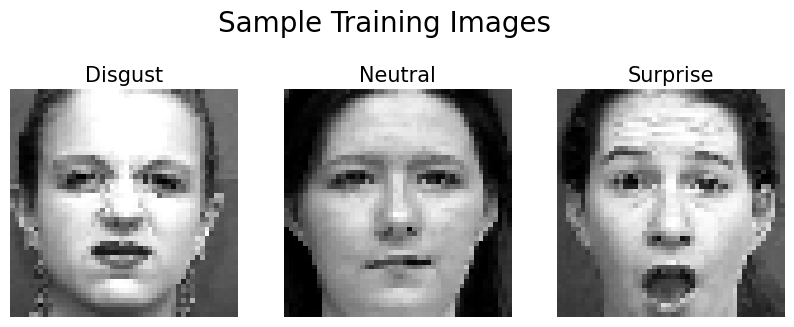

In [19]:
# showing three images in the same row with emotion in the title
def show_images(images, emotions, title):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(10, 4))
    fig.suptitle(title, fontsize=20)
    for i in range(num_images):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(emotion_mapping[emotions[i]], fontsize=15)
        axes[i].axis('off')
    plt.show()

# Selecting random rows from the DataFrame
random_rows = Train_set.sample(3)

# Convert pixel strings to NumPy arrays and visualize the images
images = []
emotions = []

for idx, row in random_rows.iterrows():
    pixel_array = string_to_pixels(row['pixels'])
    emotion = row['emotion']
    images.append(pixel_array)
    emotions.append(emotion)

# Display the images
show_images(images, emotions, "Sample Training Images")



In [9]:
# shape of the image
image_shape = string_to_pixels(pixels_column[0]).shape
print(f"Image shape: {image_shape}")


Image shape: (48, 48)


In [10]:
def process_pixels(data):
    # Keep a copy of the emotion column
    emotion = data['emotion'].copy()
    
    # Check the type of the first element in the 'pixels' column to see if it's already a list
    if isinstance(data['pixels'].iloc[0], list):
        # If the pixels are already lists, just create a new DataFrame
        data = pd.DataFrame(data['pixels'].to_list(), columns=[f'pixel{i}' for i in range(len(data['pixels'].iloc[0]))])
    else:
        # If the pixels are strings, split them into lists of integers
        data['pixels'] = data['pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])
        data = pd.DataFrame(data['pixels'].to_list(), columns=[f'pixel{i}' for i in range(len(data['pixels'].iloc[0]))])
    
    # Add the emotion column back to the data
    data['emotion'] = emotion
    return data

In [11]:
img_width = 48
img_height = 48
img_depth = 1
num_classes = 8

In [12]:
from sklearn.model_selection import train_test_split


# Process the pixel data for the training set
training = process_pixels(Train_set)

# Separate features (X) and target labels (y)
X = training.drop('emotion', axis=1)
y = training['emotion']

# Split the data into training and validation sets using train_test_split
# Here, test_size=0.2 indicates that 20% of the data will be used for validation
# random_state=42 ensures reproducibility of the split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Baseline model

In [13]:
from sklearn.dummy import DummyClassifier
import tensorflow as tf

# Reshape the training and validation data to match the input shape of the CNN model
X_train_cnn = X_train.values.reshape(-1, 48, 48, 1)
X_val_cnn = X_val.values.reshape(-1, 48, 48, 1)

# Convert the target labels to categorical
y_train_cnn = tf.keras.utils.to_categorical(y_train)
y_val_cnn = tf.keras.utils.to_categorical(y_val)

# Process the pixel data for the test set
test_processed = process_pixels(Test_set)

# Separate features (X_test) and target labels (y_test)
X_test = test_processed.drop('emotion', axis=1)
y_test = test_processed['emotion']

X_test_cnn = X_test.values.reshape(-1, 48, 48, 1)
y_test_cnn = tf.keras.utils.to_categorical(y_test)

# Create a DummyClassifier that always predicts the majority class
dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_train_cnn, y_train)  # Fit on the training set, assuming X_train_cnn is your training data

# Calculate baseline accuracy
baseline_accuracy = dummy_classifier.score(X_test_cnn, y_test)

print(f'Baseline Accuracy: {baseline_accuracy}')



Baseline Accuracy: 0.6451612903225806


# A first simple CNN model

While I acknowledge the importance of transparency and completeness in documenting the development process of our facial emotion recognition model, some elements, such as this initial simple CNN model, may not be explicitly mentioned in the final report. The decision to exclude certain details from the report stems from the realization that the results obtained from the simple CNN model were not particularly promising. However, it's crucial to emphasize that despite its exclusion from the formal report, the simple CNN model remains a significant part of this notebook's development journey. It serves as a foundational step in our exploration, providing valuable insights and informing subsequent decisions regarding model architecture and optimization strategies. Therefore, even though it may not feature prominently in the final report, the simple CNN model's role in shaping our approach and guiding our subsequent efforts should not be overlooked or underestimated.

In [29]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd  

# Define the CNN model architecture
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')  # Assuming 7 emotion classes
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape the training and validation data to match the input shape of the CNN model
X_train_cnn = X_train.values.reshape(-1, 48, 48, 1)
X_val_cnn = X_val.values.reshape(-1, 48, 48, 1)

# Convert the target labels to categorical
y_train_cnn = tf.keras.utils.to_categorical(y_train)
y_val_cnn = tf.keras.utils.to_categorical(y_val)

# Train the model
history = cnn_model.fit(X_train_cnn, y_train_cnn, validation_data=(X_val_cnn, y_val_cnn), epochs=40, batch_size=64)

# Make predictions on the validation set
cnn_val_predict = cnn_model.predict(X_val_cnn).argmax(axis=1)

# Calculate and print the accuracy
print(f'CNN Accuracy: {accuracy_score(y_val, cnn_val_predict)}')

# Generate and print the classification report
report_cnn = classification_report(y_val, cnn_val_predict)
print(report_cnn)

# Generate the confusion matrix
cm_cnn = confusion_matrix(y_val, cnn_val_predict)
cm_df_cnn = pd.DataFrame(cm_cnn, index=[str(i) for i in range(cm_cnn.shape[0])], columns=[str(i) for i in range(cm_cnn.shape[1])])

# Print the available metrics from the training history
print(history.history.keys())


Epoch 1/40


9/9 [==============================] - 2s 69ms/step - loss: 370.5575 - accuracy: 0.2500 - val_loss: 105.1528 - val_accuracy: 0.7153
Epoch 2/40
9/9 [==============================] - 0s 44ms/step - loss: 84.4673 - accuracy: 0.4826 - val_loss: 30.7362 - val_accuracy: 0.7153
Epoch 3/40
9/9 [==============================] - 0s 44ms/step - loss: 40.0777 - accuracy: 0.5903 - val_loss: 20.0981 - val_accuracy: 0.1528
Epoch 4/40
9/9 [==============================] - 0s 45ms/step - loss: 15.0725 - accuracy: 0.5660 - val_loss: 10.7125 - val_accuracy: 0.7153
Epoch 5/40
9/9 [==============================] - 0s 44ms/step - loss: 6.7059 - accuracy: 0.6215 - val_loss: 5.6519 - val_accuracy: 0.5903
Epoch 6/40
9/9 [==============================] - 0s 44ms/step - loss: 3.2473 - accuracy: 0.7274 - val_loss: 1.5528 - val_accuracy: 0.7986
Epoch 7/40
9/9 [==============================] - 0s 46ms/step - loss: 1.2520 - accuracy: 0.8385 - val_loss: 1.2911 - val_accuracy: 0.7847
Epoch 8/40
9/9 

c:\Users\oumai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\oumai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\oumai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

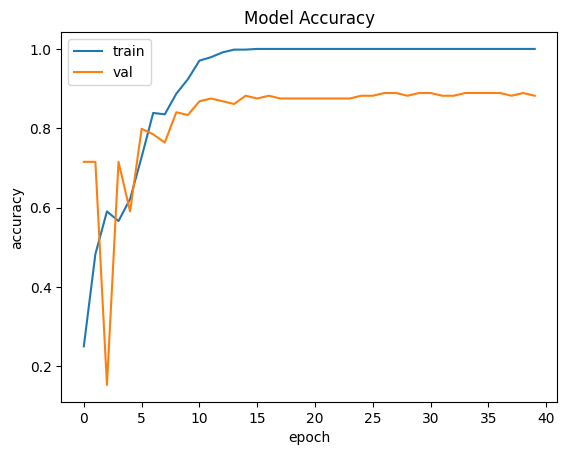

In [31]:
# let's plot the loss and accuracy for the model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [34]:

# Process the pixel data for the test set
test_processed = process_pixels(Test_set)

# Separate features (X_test) and target labels (y_test)
X_test = test_processed.drop('emotion', axis=1)
y_test = test_processed['emotion']


In [35]:
# Now let's try to predict the test data
X_test_cnn = X_test.values.reshape(-1, 48, 48, 1)
y_test_cnn = tf.keras.utils.to_categorical(y_test)

cnn_test_predict = cnn_model.predict(X_test_cnn).argmax(axis=1)

# Print the accuracy
print(f'CNN Accuracy: {accuracy_score(y_test, cnn_test_predict)}')

3/3 [==============================] - 0s 5ms/step
CNN Accuracy: 0.8494623655913979


## Classes weights

In order to address potential class imbalances within our dataset and ensure our model effectively learns from all classes, we utilize class weights during the training process. By computing class weights using the 'balanced' mode, we aim to give higher importance to underrepresented classes and lower importance to overrepresented ones. This approach helps in mitigating the impact of class imbalances on the model's learning process. Subsequently, during the training of our convolutional neural network (CNN), we pass these computed class weights to the model. By doing so, we aim to enhance the model's ability to generalize across all classes, ultimately improving its overall performance and robustness.

In [20]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Pass class_weights to the model during training
cnn_model.fit(X_train_cnn, y_train_cnn, validation_data=(X_val_cnn, y_val_cnn), epochs=40, batch_size=64, class_weight=dict(enumerate(class_weights)))


Epoch 1/40
9/9 [==============================] - 1s 51ms/step - loss: 1.5496e-04 - accuracy: 1.0000 - val_loss: 1.7815 - val_accuracy: 0.8403
Epoch 2/40
9/9 [==============================] - 0s 46ms/step - loss: 1.1892e-04 - accuracy: 1.0000 - val_loss: 1.7676 - val_accuracy: 0.8403
Epoch 3/40
9/9 [==============================] - 0s 46ms/step - loss: 9.7615e-05 - accuracy: 1.0000 - val_loss: 1.7538 - val_accuracy: 0.8403
Epoch 4/40
9/9 [==============================] - 0s 43ms/step - loss: 8.3506e-05 - accuracy: 1.0000 - val_loss: 1.7448 - val_accuracy: 0.8403
Epoch 5/40
9/9 [==============================] - 0s 43ms/step - loss: 7.6135e-05 - accuracy: 1.0000 - val_loss: 1.7385 - val_accuracy: 0.8403
Epoch 6/40
9/9 [==============================] - 0s 42ms/step - loss: 7.0260e-05 - accuracy: 1.0000 - val_loss: 1.7348 - val_accuracy: 0.8403
Epoch 7/40
9/9 [==============================] - 0s 45ms/step - loss: 6.7268e-05 - accuracy: 1.0000 - val_loss: 1.7316 - val_accuracy: 0.8403

In [21]:
# the accuracy on the test set  
cnn_test_predict = cnn_model.predict(X_test_cnn).argmax(axis=1)

# Print the accuracy on the test set
print(f'CNN Accuracy on Test Set: {accuracy_score(y_test, cnn_test_predict)}')


3/3 [==============================] - 0s 6ms/step
CNN Accuracy on Test Set: 0.8279569892473119


Let's then explore the effect of data normalization before considering further enhancements to the CNN architecture. We'll assess whether normalizing the data yields any significant improvements before diving into deeper and more complex CNN designs.

## Data Normalization

In [22]:
X_train = X_train/255
X_val = X_val/255


In [48]:
# transform the data to 4D
X_train_c = X_train.values.reshape(-1, 48, 48, 1)
X_val_c = X_val.values.reshape(-1, 48, 48, 1)

# transform the labels to categorical
y_train_c = tf.keras.utils.to_categorical(y_train)
y_val_c = tf.keras.utils.to_categorical(y_val)

# let's train again the model with the new normalized data
cnn_model.fit(X_train_c, y_train_c, validation_data=(X_val_c, y_val_c), epochs=40, batch_size=64)

# let's predict the test data
X_test = X_test/255
X_test_c = X_test.values.reshape(-1, 48, 48, 1)
y_test_c = tf.keras.utils.to_categorical(y_test)

cnn_test_predict = cnn_model.predict(X_test_c).argmax(axis=1)

# Print the accuracy
print(f'CNN Accuracy: {accuracy_score(y_test, cnn_test_predict)}')


Epoch 1/40
9/9 [==============================] - 0s 48ms/step - loss: 8.9251e-05 - accuracy: 1.0000 - val_loss: 0.7657 - val_accuracy: 0.8819
Epoch 2/40
9/9 [==============================] - 0s 43ms/step - loss: 8.1499e-05 - accuracy: 1.0000 - val_loss: 0.7787 - val_accuracy: 0.8889
Epoch 3/40
9/9 [==============================] - 0s 48ms/step - loss: 7.3437e-05 - accuracy: 1.0000 - val_loss: 0.7602 - val_accuracy: 0.8889
Epoch 4/40
9/9 [==============================] - 0s 46ms/step - loss: 6.8522e-05 - accuracy: 1.0000 - val_loss: 0.7736 - val_accuracy: 0.8889
Epoch 5/40
9/9 [==============================] - 0s 53ms/step - loss: 6.3881e-05 - accuracy: 1.0000 - val_loss: 0.7838 - val_accuracy: 0.8889
Epoch 6/40
9/9 [==============================] - 0s 46ms/step - loss: 6.0353e-05 - accuracy: 1.0000 - val_loss: 0.7706 - val_accuracy: 0.8889
Epoch 7/40
9/9 [==============================] - 0s 45ms/step - loss: 5.6374e-05 - accuracy: 1.0000 - val_loss: 0.7709 - val_accuracy: 0.8889

# DCNN

## Without data augmentation

In [49]:
# How many classes in y_train?
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")


Number of classes: 7


In [50]:
import math
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau



In [51]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer to transition from convolutional to fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer with 7 neurons (one for each class) and softmax activation for multiclass classification
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 4, 4, 128)        

In [52]:
# lets get the architecture of the model but in a table
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 4, 4, 128)        

In [53]:


# Train the model
history = model.fit(X_train_c, y_train_c, validation_data=(X_val_c, y_val_c), epochs=40, batch_size=64)

# Predictions
val_predict = model.predict(X_val_c).argmax(axis=1)

# Print the accuracy
print(f'CNN Accuracy: {accuracy_score(y_val, val_predict)}')



Epoch 1/40


9/9 [==============================] - 2s 84ms/step - loss: 9.0450 - accuracy: 0.4323 - val_loss: 1.1135 - val_accuracy: 0.7153
Epoch 2/40
9/9 [==============================] - 0s 53ms/step - loss: 1.5508 - accuracy: 0.5712 - val_loss: 1.2491 - val_accuracy: 0.7153
Epoch 3/40
9/9 [==============================] - 0s 55ms/step - loss: 1.3526 - accuracy: 0.6389 - val_loss: 1.2487 - val_accuracy: 0.7153
Epoch 4/40
9/9 [==============================] - 0s 55ms/step - loss: 1.3537 - accuracy: 0.6424 - val_loss: 1.1126 - val_accuracy: 0.7153
Epoch 5/40
9/9 [==============================] - 1s 56ms/step - loss: 1.3002 - accuracy: 0.6424 - val_loss: 1.0830 - val_accuracy: 0.7153
Epoch 6/40
9/9 [==============================] - 0s 51ms/step - loss: 1.2403 - accuracy: 0.6441 - val_loss: 1.0727 - val_accuracy: 0.7153
Epoch 7/40
9/9 [==============================] - 0s 51ms/step - loss: 1.1959 - accuracy: 0.6476 - val_loss: 1.0622 - val_accuracy: 0.7153
Epoch 8/40
9/9 [======================

In [57]:
# Now let's try to predict the test data
X_test_c = X_test.values.reshape(-1, 48, 48, 1)
y_test_c = tf.keras.utils.to_categorical(y_test)

test_predict = model.predict(X_test_c).argmax(axis=1)

# Print the accuracy
print(f'CNN Accuracy: {accuracy_score(y_test, test_predict)}')

3/3 [==============================] - 0s 7ms/step
CNN Accuracy: 0.6451612903225806


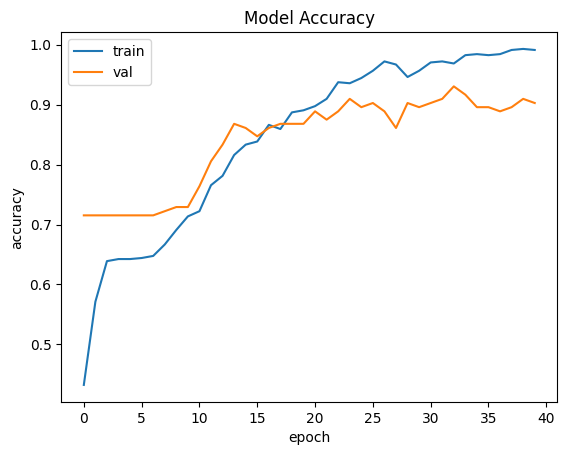

In [56]:
# let's plot the  accuracy for the model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()





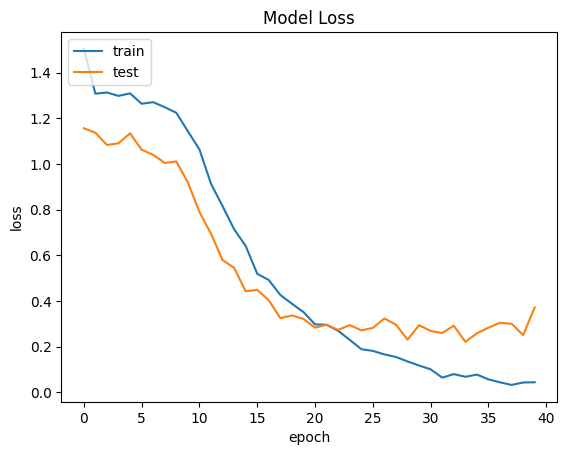

In [30]:
# let's plot the loss for the model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## With Data augmentation

In [59]:
import pandas as pd
import numpy as np
import cv2
import os

# Load data from DataFrame
data = dataset

# Define data augmentation parameters
rotation_range = 10  # Rotate images by a maximum of 10 degrees
flip_horizontal = True  # Flip images horizontally
flip_vertical = False  # Flip images vertically

augmented_data = []

# Iterate over each row in the DataFrame
for idx, row in data.iterrows():
    # Convert the pixel strings to NumPy arrays
    pixels = np.array(row['pixels'].split(), dtype=np.uint8).reshape(48, 48)
    
    # Apply data augmentation
    augmented_pixels = pixels
    
    # Rotate the image
    rotation_angle = np.random.uniform(-rotation_range, rotation_range)
    rotation_matrix = cv2.getRotationMatrix2D((24, 24), rotation_angle, 1)
    augmented_pixels = cv2.warpAffine(augmented_pixels, rotation_matrix, (48, 48))
    
    # Flip the image horizontally
    if flip_horizontal and np.random.choice([True, False]):
        augmented_pixels = cv2.flip(augmented_pixels, 1)
    
    # Flip the image vertically
    if flip_vertical and np.random.choice([True, False]):
        augmented_pixels = cv2.flip(augmented_pixels, 0)
    
    # Add the augmented data to the list
    augmented_data.append({
        'emotion': row['emotion'],
        'pixels': ' '.join(augmented_pixels.flatten().astype(str))
    })

# Convert the augmented data to a DataFrame 
augmented_df = pd.DataFrame(augmented_data)







In [60]:
import matplotlib.pyplot as plt

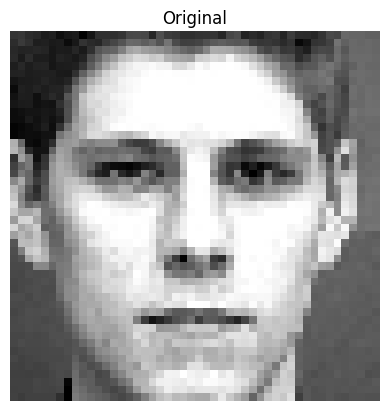

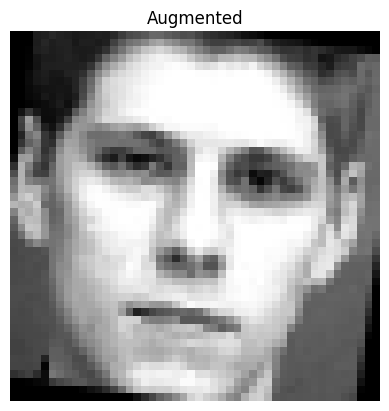

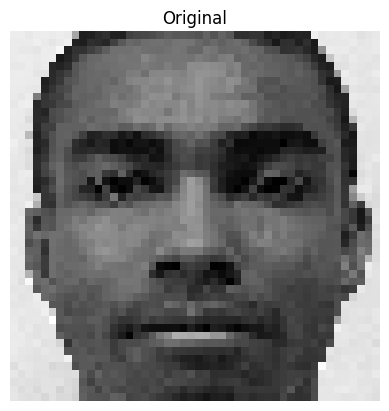

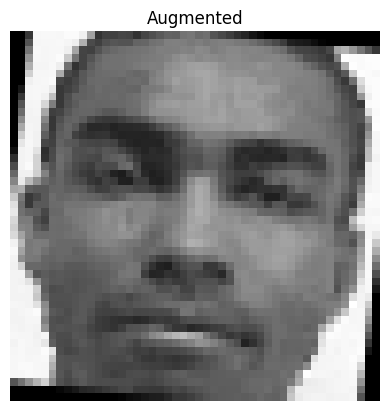

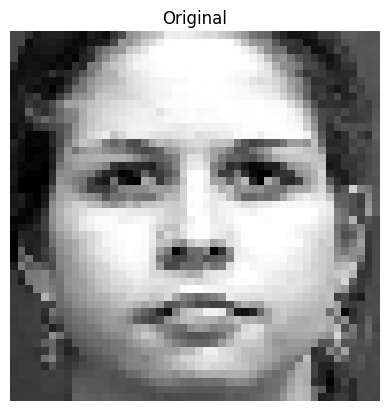

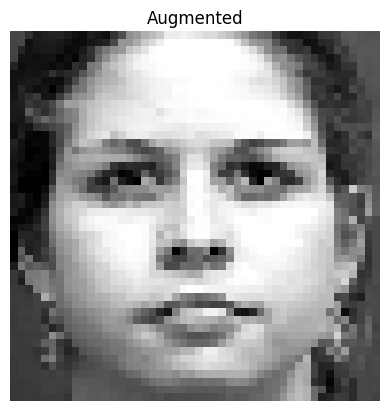

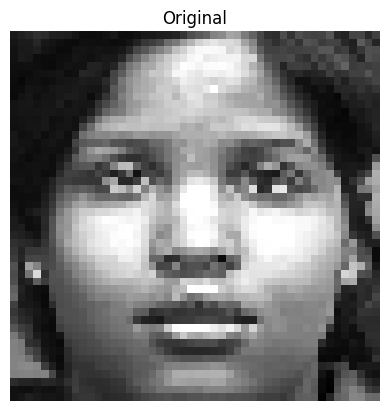

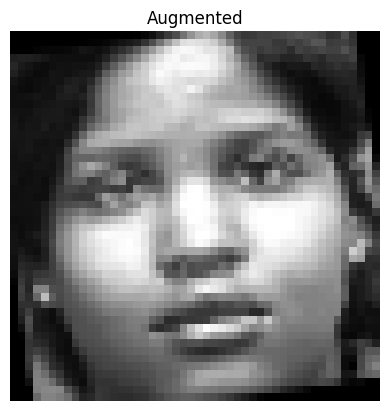

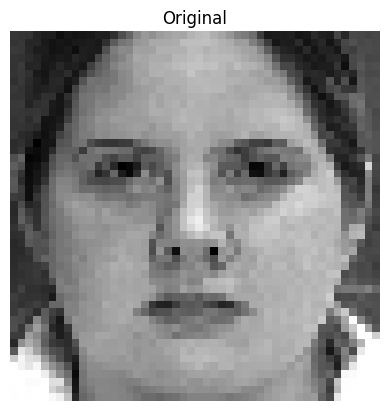

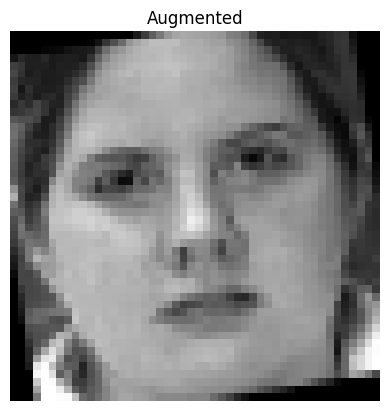

Original data: 920 samples
Augmented data: 920 samples
Combined data: 1840 samples


In [61]:
# display the original and augmented images
num_images_to_visualize = 5

# Select random rows from the DataFrame
random_rows = data.sample(num_images_to_visualize)

# Convert pixel strings to NumPy arrays and visualize the images
for idx, row in random_rows.iterrows():
    pixels = np.array(row['pixels'].split(), dtype=np.uint8).reshape(48, 48)
    augmented_pixels = np.array(augmented_df['pixels'].iloc[idx].split(), dtype=np.uint8).reshape(48, 48)
    
    # Display the original image
    plt.imshow(pixels, cmap='gray')  # Assuming grayscale images
    plt.axis('off')  
    plt.title('Original')
    plt.show()
    
    # Display the augmented image
    plt.imshow(augmented_pixels, cmap='gray')  # Assuming grayscale images
    plt.axis('off')  
    plt.title('Augmented')
    plt.show()

# Combine the original and augmented data
combined_data = pd.concat([data, augmented_df], ignore_index=True)

# Display the number of samples in the original and augmented data
print(f"Original data: {data.shape[0]} samples")
print(f"Augmented data: {augmented_df.shape[0]} samples")
print(f"Combined data: {combined_data.shape[0]} samples")



In [64]:
# let's create the train and test set
Train_set_a = combined_data[combined_data['Usage'] == 'Training']
Train_set_a=Train_set_a[Train_set_a['emotion'] != 7]
Train_set_a.drop('Usage',axis=1,inplace= True)
Train_set_a.reset_index(drop = True,inplace = True)
Train_set_a.head()


,emotion,pixels
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...


In [65]:
# now the test
Test_set_a = combined_data[combined_data['Usage'] == 'PrivateTest']
Test_set_a=Test_set_a[Test_set_a['emotion'] != 7]
Test_set_a.drop('Usage',axis=1,inplace=True)
Test_set_a.reset_index(drop = True,inplace = True)
Test_set_a.head()


,emotion,pixels
0,6,72 72 65 70 58 48 23 21 17 28 42 34 50 82 108 ...
1,6,50 36 9 4 3 4 9 13 20 55 91 123 148 158 174 18...
2,6,0 0 0 0 0 0 0 0 5 13 9 1 0 0 2 14 10 13 4 1 8 ...
3,6,19 21 21 15 10 3 26 30 32 29 10 18 48 58 50 56...
4,6,64 68 65 70 69 69 67 30 11 17 17 13 19 21 49 6...


In [66]:

from sklearn.model_selection import train_test_split



# Use the function to process the pixel data
training_a = process_pixels(Train_set_a)

# Now proceed with the rest of your code
X_a = training_a.drop('emotion', axis=1)
y_a = training_a['emotion']

X_train_a, X_val_a, y_train_a, y_val_a = train_test_split(X_a, y_a, test_size=0.2, random_state=42)

In [68]:
# transform the data to 4D
X_train_c_a= X_train_a.values.reshape(-1, 48, 48, 1)
X_val_c_a = X_val_a.values.reshape(-1, 48, 48, 1)

# transform the labels to categorical
y_train_c_a= tf.keras.utils.to_categorical(y_train_a)
y_val_c_a = tf.keras.utils.to_categorical(y_val_a)






In [69]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer to transition from convolutional to fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer with 7 neurons (one for each class) and softmax activation for multiclass classification
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()




Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 10, 10, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 4, 4, 128)        

In [70]:
from sklearn.metrics import accuracy_score

# Train the model
history = model.fit(X_train_c_a, y_train_c_a, validation_data=(X_val_c_a, y_val_c_a), epochs=40, batch_size=64)




Epoch 1/40
9/9 [==============================] - 2s 80ms/step - loss: 10.7547 - accuracy: 0.4201 - val_loss: 1.2108 - val_accuracy: 0.7153
Epoch 2/40
9/9 [==============================] - 0s 51ms/step - loss: 1.4640 - accuracy: 0.6094 - val_loss: 1.1906 - val_accuracy: 0.7153
Epoch 3/40
9/9 [==============================] - 0s 48ms/step - loss: 1.3167 - accuracy: 0.6372 - val_loss: 1.1313 - val_accuracy: 0.7153
Epoch 4/40
9/9 [==============================] - 0s 55ms/step - loss: 1.3236 - accuracy: 0.6441 - val_loss: 1.1424 - val_accuracy: 0.7153
Epoch 5/40
9/9 [==============================] - 0s 50ms/step - loss: 1.2556 - accuracy: 0.6441 - val_loss: 1.0065 - val_accuracy: 0.7153
Epoch 6/40
9/9 [==============================] - 0s 53ms/step - loss: 1.2140 - accuracy: 0.6441 - val_loss: 1.0025 - val_accuracy: 0.7153
Epoch 7/40
9/9 [==============================] - 0s 50ms/step - loss: 1.1069 - accuracy: 0.6649 - val_loss: 0.8969 - val_accuracy: 0.7292
Epoch 8/40
9/9 [==========

In [71]:
# Define the path where you want to save the model
model_path = 'Aug_images'

# Save the model
model.save(model_path)

print("Model saved successfully at:", model_path)

INFO:tensorflow:Assets written to: Aug_images\assets


INFO:tensorflow:Assets written to: Aug_images\assets


Model saved successfully at: Aug_images


In [74]:
import numpy as np

# Convert val_predict to one-hot encoded format
num_classes = y_val_c_a.shape[1]  # Get the number of classes
val_predict_one_hot = np.zeros_like(y_val_c_a)  # Initialize an array of zeros with the same shape as y_val_c_a

# Set the predicted class for each sample
for i, pred_label in enumerate(val_predict):
    val_predict_one_hot[i, pred_label] = 1

# Now you can use accuracy_score with y_val_c_a and val_predict_one_hot
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_val_c_a, val_predict_one_hot)
print(f'CNN Accuracy: {accuracy}')


CNN Accuracy: 0.8888888888888888


In [76]:
test_a = process_pixels(Test_set_a)

In [77]:
X_test_a = test_a.drop('emotion', axis=1)
y_test_a = test_a['emotion']

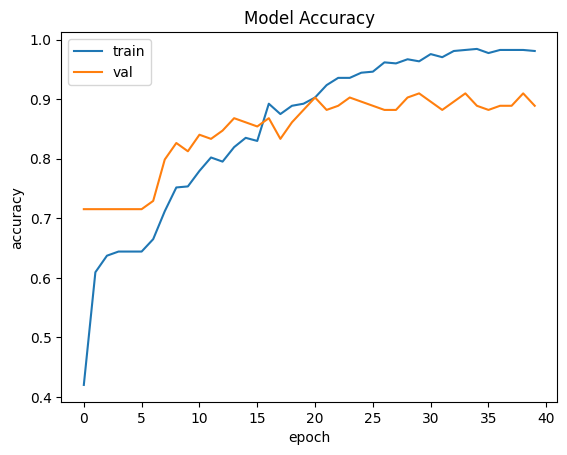

In [78]:
# plot the accuracy on the train and validation set
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [48]:
# Accuracy on the test set



X_test_c_a = X_test_a.values.reshape(-1, 48, 48, 1)
y_test_c_a = tf.keras.utils.to_categorical(y_test_a)

test_predict = model.predict(X_test_c_a).argmax(axis=1)
test_predict_one_hot = np.zeros_like(y_test_c_a)

for i, pred_label in enumerate(test_predict):
    test_predict_one_hot[i, pred_label] = 1

accuracy = accuracy_score(y_test_c_a, test_predict_one_hot)
print(f'CNN Accuracy on Test Set: {accuracy}')


3/3 [==============================] - 0s 9ms/step
CNN Accuracy on Test Set: 0.8602150537634409
